In [1]:
import rdkit
import h5py
import numpy as np
import sys
sys.path.append('../..')
sys.path.append('../../../../transformer_pytorch')
from generative_playground.rdkit_utils.rdkit_utils import NormalizedScorer
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Descriptors import NumAromaticRings
from rdkit.Chem.Draw import MolsToGridImage

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


******************************
smiles -> nonH_bond
smiles -> initial_valence_1
smiles -> initial_valence_1 nonH_bond
smiles -> initial_valence_2 double_bond
smiles -> initial_valence_3 triple_bond
initial_valence_1 -> 'F'
initial_valence_1 -> 'Cl'
initial_valence_1 -> 'Br'
initial_valence_1 -> 'I'
initial_valence_1 -> '[' 'O' '-' ']'
initial_valence_1 -> '[' 'N' 'H' '3' '+' ']'
initial_valence_2 -> 'O'
initial_valence_2 -> 'S'
initial_valence_3 -> '[' 'C' '@' 'H' ']'
initial_valence_3 -> '[' 'C' '@' '@' 'H' ']'
initial_valence_3 -> 'N'
initial_valence_3 -> '[' 'N' 'H' '+' ']'
nonH_bond -> valence_1
nonH_bond -> valence_2
nonH_bond -> valence_2 nonH_bond
nonH_bond -> valence_3 double_bond
nonH_bond -> valence_4 triple_bond
double_bond -> '=' valence_2
double_bond -> '=' valence_3
double_bond -> '=' valence_3 nonH_bond
double_bond -> '=' valence_4 double_bond
triple_bond -> '#' valence_3
triple_bond -> '#' valence_4
triple_bond -> '#' valence_4 nonH_bond
valence_4 -> 'C'
valence_4 -> '['

improving: num -> '1' inf 1 [0]
added  {'token': valence_3_num, 'num': None, 'size': 8} from <frozendict {'token': cycle_double_bond, 'num': None, 'size': 7}> via cycle_double_bond -> '=' valence_3_num
added  {'token': num, 'num': None, 'size': 8} from <frozendict {'token': valence_2_num, 'num': None, 'size': 7}> via valence_2_num -> 'O' num
added  {'token': valence_4_num, 'num': None, 'size': 8} from <frozendict {'token': valence_2_num, 'num': None, 'size': 7}> via valence_2_num -> valence_4_num '(' double_bond ')'
added  {'token': valence_2_num, 'num': None, 'size': 9} from <frozendict {'token': cycle_bond, 'num': None, 'size': 8}> via cycle_bond -> valence_2_num
improving: num -> '1' inf 1 [0]
added  {'token': num, 'num': None, 'size': 9} from <frozendict {'token': valence_2_num, 'num': None, 'size': 8}> via valence_2_num -> 'O' num
added  {'token': valence_3_num, 'num': None, 'size': 9} from <frozendict {'token': valence_2_num, 'num': None, 'size': 8}> via valence_2_num -> valence_

In [2]:
!dir "../train/pretrained/paper/"

 Volume in drive C is OS
 Volume Serial Number is 126A-86DF

 Directory of C:\Users\egork\Dropbox\GitHub\deep_games\generative_playground\src\generative_playground\train\pretrained\paper

10/06/2018  11:04 AM    <DIR>          .
10/06/2018  11:04 AM    <DIR>          ..
10/03/2018  07:36 AM           574,224 pg_smiles_anchor_weak.h5
10/02/2018  08:04 PM        64,964,759 pg_smiles_anchor_weak_sa20.h5
10/01/2018  07:22 AM        35,340,958 pg_smiles_anchor_wweak_sa20.h5
10/02/2018  08:02 PM        63,763,960 pg_smiles_anchor_wweak_sa20_cycle.h5
10/03/2018  07:20 AM        31,595,205 pg_smiles_no_anchor.h5
09/19/2018  03:06 PM         4,500,260 policy_gradient_baseline.h5
               6 File(s)    200,739,366 bytes
               2 Dir(s)  741,163,814,912 bytes free


In [3]:
from collections import OrderedDict
runs = OrderedDict(reversed([('Unconstrained',{'file':'pg_smiles_no_anchor.h5','range': 200}),
                   ('Weak Anchor, SA penalty',{'file':'pg_smiles_anchor_wweak_sa20.h5','range':1600}),
                   ('Weak Anchor, SA penalty + arom.cycle limit',{'file':'pg_smiles_anchor_wweak_sa20_cycle.h5','range':3850}),
                   ('Strong Anchor, SA penalty',{'file':'pg_smiles_anchor_weak_sa20.h5','range':5800})]))
runs

OrderedDict([('Strong Anchor, SA penalty',
              {'file': 'pg_smiles_anchor_weak_sa20.h5', 'range': 5800}),
             ('Weak Anchor, SA penalty + arom.cycle limit',
              {'file': 'pg_smiles_anchor_wweak_sa20_cycle.h5', 'range': 3850}),
             ('Weak Anchor, SA penalty',
              {'file': 'pg_smiles_anchor_wweak_sa20.h5', 'range': 1600}),
             ('Unconstrained',
              {'file': 'pg_smiles_no_anchor.h5', 'range': 200})])

In [4]:
def get_smiles_bunches(runs):
    bunches = []
    for key, value in runs.items():
        smiles_file = h5py.File('../train/pretrained/paper/' + runs[key]['file'],'r')
        smiles = np.array(smiles_file['smiles'])[runs[key]['range']*40:(runs[key]['range']+100)*40]
        bunches.append((key,smiles))
    return bunches

In [5]:
smiles_bunches = get_smiles_bunches(runs)
kusner1 ='CCCc1ccc(I)cc1C1CCC-c1'
kusner2 ='CC(C)CCCCCc1ccc(Cl)nc1'
kusner3 ='CCCc1ccc(Cl)cc1CCCCOC'
jin = 'c1c(Cl)ccc2c1cc(C(=O)C)c(C(=O)Nc3cc(NC(=O)Nc4cc(c5ccccc5(C))ccc4)ccc3)c2'

smiles_bunches = [('Kusner et al.', [kusner1, kusner2, kusner3]),
                  ('Jin et al.',[jin])] \
                    + smiles_bunches
smiles_bunches

[('Kusner et al.',
  ['CCCc1ccc(I)cc1C1CCC-c1',
   'CC(C)CCCCCc1ccc(Cl)nc1',
   'CCCc1ccc(Cl)cc1CCCCOC']),
 ('Jin et al.',
  ['c1c(Cl)ccc2c1cc(C(=O)C)c(C(=O)Nc3cc(NC(=O)Nc4cc(c5ccccc5(C))ccc4)ccc3)c2']),
 ('Strong Anchor, SA penalty',
  array(['CCc1csc([C@@H](C)NC(=O)Nc2ccc([N+](=O)[O-])cc2)n1',
         'NC(=O)c1c(Cl)cc(S(=O)(=O)c2ccc(F)c([N+](=O)[O-])c2)cc1',
         'COC(=O)CCC(=O)c1cccc(NC(=O)c2ccc(Cl)cc2)c1', ...,
         'CCC(C)(C)[C@@H](C)CNC(=O)[C@H]1CC(=O)N([C@@H](CC)c2ccc(Cl)cc2)C1',
         'COC(=O)C[C@H](O)c1c(F)cccc1N',
         'CNC(=O)c1ccc(C)c(C(=O)Nc2ccccc2C(F)(F)F)c1'], dtype=object)),
 ('Weak Anchor, SA penalty + arom.cycle limit',
  array(['Oc1ccc(CNc2ncc(Oc3ccc(c4ccc(c5ccccc5)c(Cl)c4)cc3)c(Cc3cccs3)c2)cc1',
         'Cc1ccc(CS(=O)(=O)c2cc(N3CCC(CC(=O)N(Cc4ccc(Cl)cc4)C)C3)c(C)cc2)cc1',
         'Cc1cc([N+](=O)[O-])ccc1Nc1ccc(CSc2nc(C3CCCC3)cs2)cc1Br', ...,
         'CC(=O)NCc1ccc(CNc2ccc(Cl)cc2Nc2ccc(Cl)cc2Cl)cc1',
         'Cc1ccc(NC(=O)C(=O)N2CC[C@@H](Cc3cccc(C

In [8]:
def get_all_metrics(smiles):
    mols = [MolFromSmiles(s) for s in smiles]
    scores, norm_scores = NormalizedScorer().get_scores_from_mols(mols)
    arom_rings = np.array([NumAromaticRings(m) for m in mols])
    metrics = np.concatenate([scores.sum(axis=1)[:,None], 
                              norm_scores.sum(axis=1)[:,None], 
                              scores[:,1][:,None], 
                              norm_scores[:,1][:,None],
                              arom_rings[:,None]], 
                             axis=1)
    neg_sa = norm_scores[:,1] < 0 # we're only interested in positive SA
    pos_sa_scores = metrics[:,1]
    pos_sa_scores[neg_sa] = -100
#     if 'cycle' in key:
#         pos_sa_scores[arom_rings>6] = -100
    best_ind = np.argmax(pos_sa_scores)
    return best_ind, metrics[best_ind, :], smiles[best_ind]

In [9]:
metrics_list = []
for name, s in smiles_bunches:
    metrics_list.append(get_all_metrics(s))
    print(name, metrics_list[-1])


Kusner et al. (1, array([ 2.56397897,  2.93391534, -1.92992103,  1.34560546,  1.        ]), 'CC(C)CCCCCc1ccc(Cl)nc1')
Jin et al. (0, array([ 6.24044483,  5.29827012, -2.32707517,  0.86986354,  5.        ]), 'c1c(Cl)ccc2c1cc(C(=O)C)c(C(=O)Nc3cc(NC(=O)Nc4cc(c5ccccc5(C))ccc4)ccc3)c2')
Strong Anchor, SA penalty (3478, array([ 6.5176555 ,  5.67555635, -1.9595445 ,  1.31012018,  5.        ]), 'O=C(Nc1cccc(c2ccc(OCc3ccccc3)cc2)c1)c1ccc(SCc2ccccc2)cc1')
Weak Anchor, SA penalty + arom.cycle limit (2168, array([12.60009186,  9.48105737, -2.82860814,  0.26908858,  7.        ]), 'O=C(Nc1cc(c2cccc(Cl)c2)c(Oc2ccc(c3cc(Cl)c(Br)cc3c3ccc(Cl)cc3)cc2)cc1)c1c(Cl)c(c2c(Cl)cccc2)ccc1')
Weak Anchor, SA penalty (1469, array([16.68184815, 12.24984947, -2.98235185,  0.08492248, 12.        ]), 'O=C(c1c(c2ccc(Nc3cccc(c4c(c5ccccc5)c(c5ccc(c6ccc(c7cc(c8ccccc8)ccc7)cc6)cc5)cc(c5ccccc5)c4)c3)cc2)cccc1)c1ccccc1c1ccccc1')
Unconstrained (3185, array([64.3076    , 46.44669305, -1.        ,  2.45953675, 13.        ]), 'Br

In [10]:
best_smiles = [m[2] for m in metrics_list]
legends =[sb[0] for sb in smiles_bunches]
best_mols = [MolFromSmiles(s) for s in best_smiles]
# now let's output this nicely for LaTeX
for sb, m_ in zip (smiles_bunches, metrics_list):
    m = list(m_[1])
    m[-1] = int(m[-1])
    print(  sb[0] +' & {:.2f} & {:.2f} & {:.2f} & {:d} \\\\'.format(*m[1:]))

Kusner et al. & 2.93 & -1.93 & 1.35 & 1 \\
Jin et al. & 5.30 & -2.33 & 0.87 & 5 \\
Strong Anchor, SA penalty & 5.68 & -1.96 & 1.31 & 5 \\
Weak Anchor, SA penalty + arom.cycle limit & 9.48 & -2.83 & 0.27 & 7 \\
Weak Anchor, SA penalty & 12.25 & -2.98 & 0.08 & 12 \\
Unconstrained & 46.45 & -1.00 & 2.46 & 13 \\


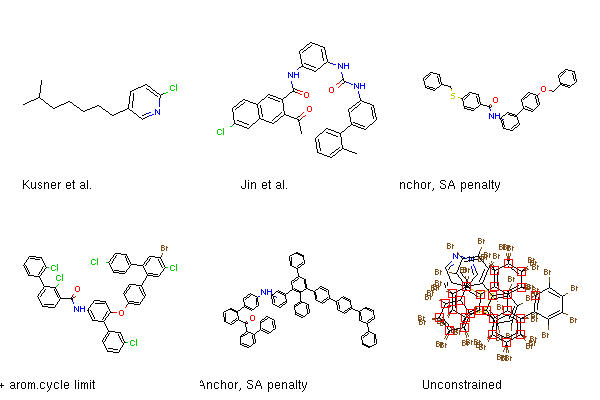

In [11]:
MolsToGridImage(best_mols, molsPerRow=3, subImgSize=(200, 200), legends=legends, useSVG=False)